<a href="https://colab.research.google.com/github/Vhaatever/Online-Proctoring/blob/main/Online_proctoring_software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries
import cv2
import numpy as np
import os
import PIL
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
# Set root directory
root_dir='/content/drive/MyDrive/AI Project/Base'


In [ ]:
os.chdir(root_dir)

In [ ]:
ls

Blank/  Multi_written/  Single_written/


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set dimensions to resize the images in dataset
height=256
width=256

In [ ]:
# Class to preprocess the dataset
class PaperDataset(Dataset):
  def __init__(self, root_dir, train, imagenet=False):
    self.root_dir = root_dir
    self.train = train
    self.imagenet = imagenet

    all_data_list = []

    label_names = os.listdir(root_dir)

    for label_name in label_names:
      label = label_name
      
      fnames = os.listdir(os.path.join(root_dir, label_name))
      for fname in fnames:
        fpath = os.path.join(root_dir, label_name, fname)
        all_data_list.append({
            'path':fpath,
            'label':label
        })

    # Split into train and test data
    train_list, test_list = train_test_split(all_data_list, test_size=0.2, random_state=42)

    self.data_list = train_list if self.train is True else test_list
    self.idx_to_class = {i:j for i,j in enumerate(label_names)}
    self.class_to_idx = {value:key for key, value in self.idx_to_class.items()}
    # print

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, index):
    img_path = self.data_list[index]['path']
    img_label = self.data_list[index]['label']

    if self.imagenet:
      img = Image.open(img_path).convert('RGB')
    else:
      img = Image.open(img_path).convert('L')

    if self.imagenet:
      tfms = transforms.Compose([
          transforms.Resize(size=(224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
    else:
      tfms = transforms.Compose([
          transforms.Resize(size=(256, 256)),
          transforms.ToTensor(),
          transforms.Normalize(mean=0.5, std=0.5)
      ])

    img = tfms(img)
    label = self.class_to_idx[img_label]

    return img, label

In [ ]:
# Instantiate train and test data for preprocessing
train_dataset = PaperDataset(root_dir, train=True)
test_dataset = PaperDataset(root_dir, train=False)

vgg_train_dataset = PaperDataset(root_dir, train=True, imagenet=True)
vgg_test_dataset = PaperDataset(root_dir, train=False, imagenet=True)

In [ ]:
# Load data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

vgg_train_loader = DataLoader(vgg_train_dataset, batch_size=10, shuffle=True)
vgg_test_loader = DataLoader(vgg_test_dataset, batch_size=1, shuffle=False)

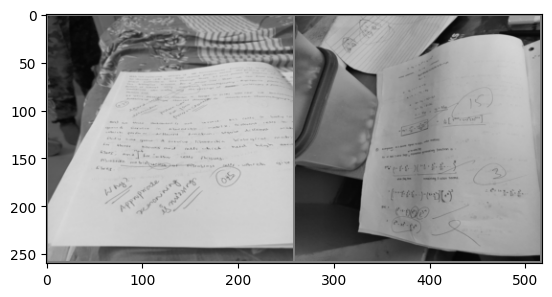

In [ ]:
# Functions to show an image
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

In [ ]:
'''class VGGNet(nn.Module):
  def __init__(self, num_channels=1, num_classes=3):
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
      param.requires_grad = False

    model[-1] = nn.Linear(4096, out_features=num_classes)
    self.model = model

  def forward(self, x):
    outputs = self.model(x)
    return outputs

vgg_net = VGGNet()'''

'class VGGNet(nn.Module):\n  def __init__(self, num_channels=1, num_classes=3):\n    model = models.vgg16(pretrained=True)\n    \n    for param in model.parameters():\n      param.requires_grad = False\n\n    model[-1] = nn.Linear(4096, out_features=num_classes)\n    self.model = model\n\n  def forward(self, x):\n    outputs = self.model(x)\n    return outputs\n\nvgg_net = VGGNet()'

In [ ]:
num_classes=3
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
  param.requires_grad=False

#vgg16[-1] = nn.Linear(4096, num_classes)
vgg16.fc=nn.Linear(4096, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Get basic Net module to train on multiple CNN filters
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
# Instantiate optimizer
import torch.optim as optim

epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
vgg_optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

In [ ]:
# Function to train model
def train_model(epochs, train_loader, net, criterion, optimizer):
  losses = []
  for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss= 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # zero the parameter gradients
        vgg_optimizer.zero_grad()

        # forward + backward + optimize
        with torch.set_grad_enabled(True):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f}')   
             
    losses.append(running_loss)
  print('Finished Training')
  return losses

In [ ]:
# Train the model
custom_model_losses = train_model(epochs, train_loader, net.to(device), criterion, optimizer)

[1,   100] loss: 110.618
[2,   100] loss: 194.811
[3,   100] loss: 504.667
[4,   100] loss: 622.459
[5,   100] loss: 932.561
[6,   100] loss: 1972.549
[7,   100] loss: 1363.463
[8,   100] loss: 1911.725
[9,   100] loss: 2976.022
[10,   100] loss: 3844.477
[11,   100] loss: 4484.404
[12,   100] loss: 1908.603
[13,   100] loss: 6696.144
[14,   100] loss: 1636.567
[15,   100] loss: 3815.699
[16,   100] loss: 5859.230
[17,   100] loss: 8406.065
[18,   100] loss: 8964.608
[19,   100] loss: 10167.954
[20,   100] loss: 9090.252
[21,   100] loss: 7231.661
[22,   100] loss: 2552.811
[23,   100] loss: 10399.733
[24,   100] loss: 12302.372
[25,   100] loss: 4430.330
[26,   100] loss: 9276.465
[27,   100] loss: 16041.783
[28,   100] loss: 16719.148
[29,   100] loss: 11314.948
[30,   100] loss: 4697.483
[31,   100] loss: 15204.025
[32,   100] loss: 17456.753
[33,   100] loss: 9553.405
[34,   100] loss: 6466.533
[35,   100] loss: 17720.986
[36,   100] loss: 21833.960
[37,   100] loss: 19099.606
[38,

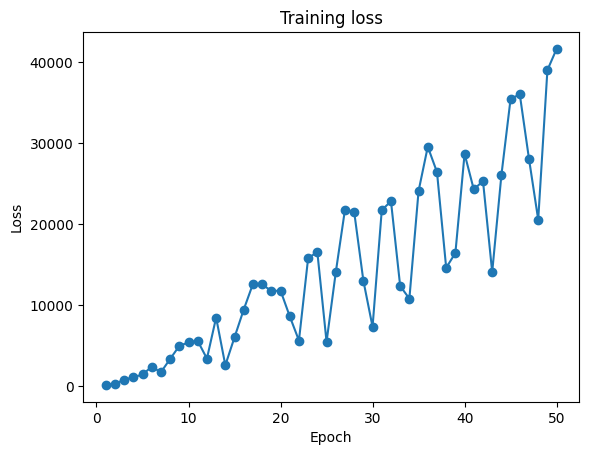

In [ ]:
# Plot the losses
x = list(range(1,epochs + 1))
y = list(custom_model_losses)

data = list(zip(x, y))
plt.plot(x, y, marker='o')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/AI Project/Checkpoints/model_3.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 30 %


In [ ]:
# Simulation
input_video='/content/drive/MyDrive/AI Project/Test'

time_diff=1000


label_names = os.listdir(input_video)
video_list=[]

tfms = transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])

for label_name in label_names:
  label = label_name
  fnames = os.listdir(os.path.join(input_video, label_name))
  for fname in fnames:
    fpath = os.path.join(input_video, label_name, fname)
    video_list.append({
        'path':fpath,
        'label':label
    })

    image_list=[]
    cap= cv2.VideoCapture(fpath)
    
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
      print("Error opening video stream or file")

    multi=0
    single=0
    blank=0

    # Read until video is completed
    """while(input_stream.isOpened()):
      # Capture frame-by-frame
      count = 0
      success,image = input_stream.read()
      image_list.append(image)
      while success:
        #cv2.imwrite("frame%d.jpg" % count, image)     
        input_stream.set(cv2.CAP_PROP_POS_MSEC,(count*time_diff))    # move the time
        success,image = input_stream.read()
        image_list.append(image)
        count += 1
      # release after reading  """

    while True:
      ret, frame = cap.read()
      if not ret: break # break if no next frame
      
      #cv2.imshow(frame) # show frame
      image_list.append(frame)
      if cv2.waitKey(1) & 0xFF == ord('q'): # on press of q break
          break

      # release and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    
    button=True  
    cap.release()
    count=0
    threshold=0.1
    for image in image_list:
      image = PIL.Image.fromarray(image)
      image=image.convert('L')
      image=tfms(image)
      image=image[None,:]
      output=net(image)
      softmax=nn.Softmax(dim=1)
      output=softmax(output)

      outputs = output.tolist()[0]
      #print(outputs)

      multi+=outputs[2]
      blank+=outputs[1]
      count+=1
      if button==True:
        single+=outputs[2]
      

      if multi+single>threshold*count:
        print(f'[{count}, {multi}, {single}, {blank}]')
        print("flag")
        